In [1]:
import tensorflow as tf
import numpy as np


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGPJ3IL/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGPJ3IL/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGPJ3IL/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = imdb['train'], imdb['test']

In [4]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [5]:
training_sentences[0]

'b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."'

In [6]:
training_labels[0]

0

In [7]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [9]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i 

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 2s 3ms/step - loss: 0.5173 - accuracy: 0.7539 - val_loss: 0.3757 - val_accuracy: 0.8345
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3228 - accuracy: 0.8641 - val_loss: 0.3574 - val_accuracy: 0.8412
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2670 - accuracy: 0.8920 - val_loss: 0.3763 - val_accuracy: 0.8348
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2325 - accuracy: 0.9085 - val_loss: 0.4019 - val_accuracy: 0.8278
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2074 - accuracy: 0.9205 - val_loss: 0.4374 - val_accuracy: 0.8228
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1870 - accuracy: 0.9299 - val_loss: 0.4792 - val_accuracy: 0.8188
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1688 - accuracy: 0.9378 - val_loss: 0.5311 - val_accuracy: 0.8118
Epoch 

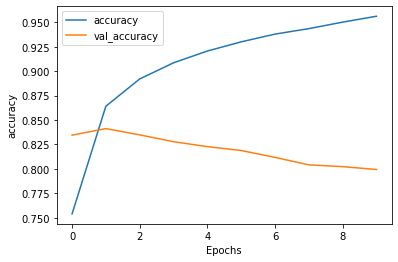

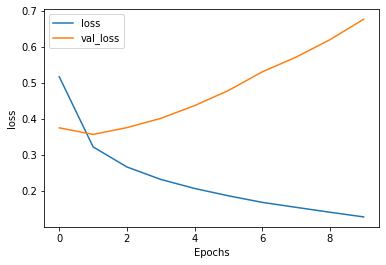

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(32, 2, activation='relu'),
    #tf.keras.layers.LSTM(64),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 99, 32)            1056      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [14]:

num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))
#history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 0.5977 - accuracy: 0.6434 - val_loss: 0.3915 - val_accuracy: 0.8277
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3755 - accuracy: 0.8337 - val_loss: 0.3661 - val_accuracy: 0.8375
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3130 - accuracy: 0.8668 - val_loss: 0.3777 - val_accuracy: 0.8312
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2791 - accuracy: 0.8828 - val_loss: 0.4126 - val_accuracy: 0.8174
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2581 - accuracy: 0.8930 - val_loss: 0.4159 - val_accuracy: 0.8202
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2438 - accuracy: 0.8984 - val_loss: 0.4505 - val_accuracy: 0.8082
Epoch 7/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2306 - accuracy: 0.9046 - val_loss: 0.4516 - val_accuracy: 0.8115
Epoch 

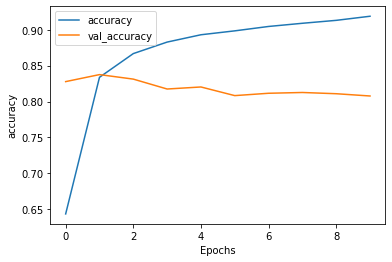

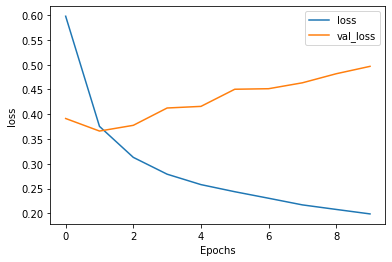

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [18]:
new_sentences = [
    'I loved this movie.',
    'This film is so boring.',
    'This movie is so hilarious. I had a really great time!',
    'Very linear scenario, no surprises at all',
    'Another amazing addition to the franchise with good story arcs and standalone episodes.',
    'Not for the hardened not even the casual fans.'
    ]
new_sequences = tokenizer.texts_to_sequences(new_sentences)
padded=pad_sequences(new_sequences, maxlen=max_length,truncating=trunc_type)
output=model.predict(padded)
for i in range(0,len(new_sentences)):
    print('Review:'+new_sentences[i]+' '+'sentiment:'+str(output[i])+'\n')

Review:I loved this movie. sentiment:[0.7176274]

Review:This film is so boring. sentiment:[0.52462786]

Review:This movie is so hilarious. I had a really great time! sentiment:[0.83763087]

Review:Very linear scenario, no surprises at all sentiment:[0.8178184]

Review:Another amazing addition to the franchise with good story arcs and standalone episodes. sentiment:[0.6473206]

Review:Not for the hardened not even the casual fans. sentiment:[0.96109796]

